In [146]:
import numpy as np
from scipy.spatial import cKDTree
from tqdm import tqdm
import time
from scipy import sparse
import networkx as nx
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from colorsys import hls_to_rgb

def get_distinct_colors(n):
    colors = []
    for i in np.arange(0., 360., 360. / n):
        h = i / 360.
        l = (50 + np.random.rand() * 10) / 100.
        s = (90 + np.random.rand() * 10) / 100.
        colors.append(hls_to_rgb(h, l, s))
    return colors

def distance_matrix(X, Y):
    A, _ = np.shape(X)
    B, _ = np.shape(Y)
    X2 = np.sum(X**2, axis=1).reshape(-1,1)
    Y2 = np.sum(Y**2, axis=1).reshape(-1,1)
    XY = X.dot(Y.T)
    dm = X2 - 2*XY + Y2.T
    return np.sqrt(dm)

def get_lil_matrix(num_nodes, graph_dict):
    I, J, V = [], [], []
    for src_dst, weight in graph_dict.items():
        I.append(src_dst[0])
        J.append(src_dst[1])
        V.append(weight)
    lil_matrix = sparse.lil_matrix((num_nodes, num_nodes))
    lil_matrix[I,J] = V
    lil_matrix[J,I] = V
    return lil_matrix

class SpringyKNN:
    def __init__(self, x, y, randomize=True, num_pivots=5000):
        self.n = x.shape[0] # number of data points
        
        perm = np.arange(self.n)
        if randomize:
            perm = np.random.permutation(self.n)
            
        self.x = x[perm]
        self.y = y[perm]
        
        self.p = num_pivots # number of pivots
        self.pivots_x = self.x[:num_pivots]
        self.pivots_y = self.y[:num_pivots]
        
    def knn_in_pivots(self, k=10):
        print("Started kNN of data on pivots...")
        start = time.time()

        sorted_dm = np.zeros((self.n,k))
        sorted_indices = np.zeros((self.n,k))

        kdtree = cKDTree(self.pivots_x, leafsize=40)
        sorted_dm, sorted_indices = kdtree.query(self.x, k=k, p=2)

        end = time.time()
        print("Finished kNN of data on pivots in ", (end - start), " secs")
        return sorted_dm, sorted_indices.astype(int)
    
    def compute_spring_strengths(self, sorted_dm, sorted_indices, use_pivots_dm=False):
        print("Started spring strength computation between pivots...")
        start = time.time()
        
        pivots_dm = None
        if use_pivots_dm:
            pivots_dm = distance_matrix(self.pivots_x, self.pivots_x)
            
        N,k = sorted_dm.shape
        spring_strengths = {}
        for n in tqdm(range(N)):
            for i in range(k):
                for j in range(i+1,k):
                    di = sorted_dm[n,i]
                    dj = sorted_dm[n,j]
                    pi = int(sorted_indices[n,i])
                    pj = int(sorted_indices[n,j])
                    if pi == n or pj == n:
                        continue
                    if pi > pj:
                        pi,pj = pj,pi
                        di,dj = dj,di
                    edge = (pi,pj)
                    if edge in spring_strengths:
                        spring_strengths[edge]+=(1/(di+dj+1e-12))
                    else:
                        if pivots_dm is None:
                            D = np.sqrt(np.sum((self.pivots_x[pi]-self.pivots_x[pj])**2) + 1e-12)
                        else:
                            D = pivots_dm[pi,pj]
                        spring_strengths[edge]=((1/D) + (1/(di+dj+1e-12)))
                        
        end = time.time()
        print("Finished spring strength computation in ", (end - start), " secs")
        return spring_strengths
    
    def get_pivots_knn(self, spring_strengths, k=10):
        print("Started kNN graph computation from lil_matrix...")
        start = time.time()
        
        lil_matrix = get_lil_matrix(self.p, spring_strengths)
        
        num_nodes,_ = lil_matrix.shape
        spring_graph = {}
        graph_nodes = set()
        for p in tqdm(range(num_nodes)):
            neighbors = np.asarray(lil_matrix.rows[p])
            neighbor_dist = np.asarray(lil_matrix.data[p])
            num_neighbors = len(neighbors)

            nn_indices = None
            if num_neighbors > k:
                nn_indices = np.argpartition(neighbor_dist, kth=num_neighbors-k)[-k:].astype(int)
            elif num_neighbors > 0:
                nn_indices = range(num_neighbors)

            if nn_indices is None:
                continue
            else:
                graph_nodes.add(p)
                nn_dist = neighbor_dist[[nn_indices]]
                nn_pivots = neighbors[[nn_indices]]
                for j in range(len(nn_indices)):
                    pi = p
                    pj = nn_pivots[j]
                    dij = nn_dist[j]
                    if pi > pj:
                        pi,pj = pj,pi
                    edge = (pi,pj)
                    if not(edge in spring_graph):
                        spring_graph[edge]=dij
                        
        end = time.time()
        print("Finished kNN graph of pivots in ", (end - start), " secs")
        return list(graph_nodes), spring_graph
    
    def get_networkx_graph(self, graph_nodes, spring_graph_dict):
        print("Preparing networkx graph...")
        start = time.time()
        
        G=nx.Graph()
        for i in graph_nodes:
            G.add_node(i, CLASS=int(self.pivots_y[i]))

        weighted_edges = []
        for src_dst, strength in spring_graph_dict.items():
            weighted_edges.append((src_dst[0],src_dst[1],strength))

        G.add_weighted_edges_from(weighted_edges)
        
        end = time.time()
        print("Finished preparing networkx graph in ", (end - start), " secs")
        return G
    
    def write_gexf(self, G, filename='springyknn_graph.gexf'):
        # Visualize using Gephi software's forceatlas2 layout
        nx.write_gexf(G, filename)
        print("Saved gexf file")
        
    def viz_spring_graph(self, G, dim=2, iterations=150, scale=1.0):
        print("Preparing networkx visualization...")
        start = time.time()

        y = self.pivots_y
        
        print("Computing circular layout positions...")
        cir_pos = nx.circular_layout(G, dim=dim, scale=scale)
        end = time.time()
        print("Finished computing circular layout positions in ", (end - start), " secs")

        #print("Computing spectral layout positions...")
        #start_spectral = time.time()
        #spec_pos = nx.spectral_layout(G, dim=dim, scale=scale)
        #end = time.time()
        #print("Finished computing spectral layout positions in ", (end - start), " secs")

        print("Computing spring layout positions...")
        start_spring = time.time()
        pos = nx.spring_layout(G, pos=None, dim=dim, iterations=iterations, scale=scale)
        end = time.time()
        print("Finished computing spring layout positions in ", (end - start_spring), " secs")

        %matplotlib notebook
        plt.ion()
        y_vals = np.unique(y)
        y_min = int(np.min(y))
        y_max = int(np.max(y))
        colors = get_distinct_colors(y_max-y_min+1)
        custom_cmap = ListedColormap(colors)
        for n in G.nodes():
            nx.draw_networkx_nodes(G, pos, with_labels=False, nodelist=[n], node_size=5,
                                   node_color=colors[(int(y[n])-y_min)])
        sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=plt.Normalize(vmin=y_min, vmax=y_max))
        sm.set_array([])
        plt.axis('off')
        plt.colorbar(sm)
        plt.show()
        
        end = time.time()
        print("Finished networkx visualization in ", (end - start), " secs")
        
    def get_springy_knn_graph(self, k1=10, k2=10):
        sorted_dm, sorted_indices = self.knn_in_pivots(k=k1)
        spring_strengths = self.compute_spring_strengths(sorted_dm, sorted_indices)
        graph_nodes, spring_graph = self.get_pivots_knn(spring_strengths, k=k2)
        G = self.get_networkx_graph(graph_nodes, spring_graph)
        return G

In [193]:
class KNNClassifier:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.kdtree = cKDTree(self.x, leafsize=40)
        
    def predict(self, x, k=5):
        N,_ = x.shape
        sorted_dm, sorted_indices = self.kdtree.query(x, k=k, p=2)
        predictions = np.zeros((N,1))
        for n in range(N):
            nn_classes = self.y[sorted_indices[n]].reshape(-1).astype(int)
            predictions[n] = np.argmax(np.bincount(np.sort(nn_classes)))
        return predictions
    
    def accuracy(self, x, y, k=5):
        p = self.predict(x, k=k)
        return np.mean(p==y)
    
    def predict_dm(self, x, k=5):
        dm = distance_matrix(x, self.x)
        indices = np.argsort(dm, axis=1)[:,:k]
        return stats.mode(self.y[indices], axis=1).mode.reshape(-1,1)
    
    def accuracy_dm(self, x, y, k=5):
        p = self.predict_dm(x, k=k)
        return np.mean(p==y)
    
def partition_data(x,y, training=0.7, cross_validation=0.15, test=0.15):
    if training+cross_validation+test != 1.0:
        print("Invalid training or cross_validation or test factors!!")
        return
    N = x.shape[0]
    rndperm = np.random.permutation(N)
    
    x_train = x[rndperm][:int(training*N)]
    y_train = y[rndperm][:int(training*N)].reshape(-1,1)

    x_cv = x[rndperm][int(training*N):int((training+cross_validation)*N)]
    y_cv = y[rndperm][int(training*N):int((training+cross_validation)*N)].reshape(-1,1)

    x_test = x[rndperm][int((training+cross_validation)*N):N]
    y_test = y[rndperm][int((training+cross_validation)*N):N].reshape(-1,1)
    
    return x_train, y_train, x_cv, y_cv, x_test, y_test

In [52]:
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA

mnist = fetch_mldata("MNIST original")
pca = PCA(n_components=100)
MX = pca.fit_transform(mnist.data / 255.0)
#MX = mnist.data / 255.0
My = mnist.target
print('Explained total variation: ,', format(sum(pca.explained_variance_ratio_)))
print(MX.shape)

Explained total variation: , 0.9146004226952927
(70000, 100)


In [147]:
springyknn = SpringyKNN(MX, My, randomize=True, num_pivots=5000)
G = springyknn.get_springy_knn_graph(k1=10, k2=5)
springyknn.write_gexf(G, filename='mnist_springyknn_graph.gexf')

Started kNN of data on pivots...


  0%|          | 115/70000 [00:00<01:00, 1146.33it/s]

Finished kNN of data on pivots in  45.969595193862915  secs
Started spring strength computation between pivots...


100%|██████████| 70000/70000 [00:20<00:00, 3359.81it/s]


Finished spring strength computation in  20.836510181427002  secs
Started kNN graph computation from lil_matrix...


100%|██████████| 5000/5000 [00:00<00:00, 19137.57it/s]


Finished kNN graph of pivots in  1.6245968341827393  secs
Preparing networkx graph...
Finished preparing networkx graph in  0.06817197799682617  secs
Saved gexf file


Preparing networkx visualization...
Computing circular layout positions...
Finished computing circular layout positions in  0.0022368431091308594  secs
Computing spring layout positions...
Finished computing spring layout positions in  255.18749117851257  secs


<IPython.core.display.Javascript object>


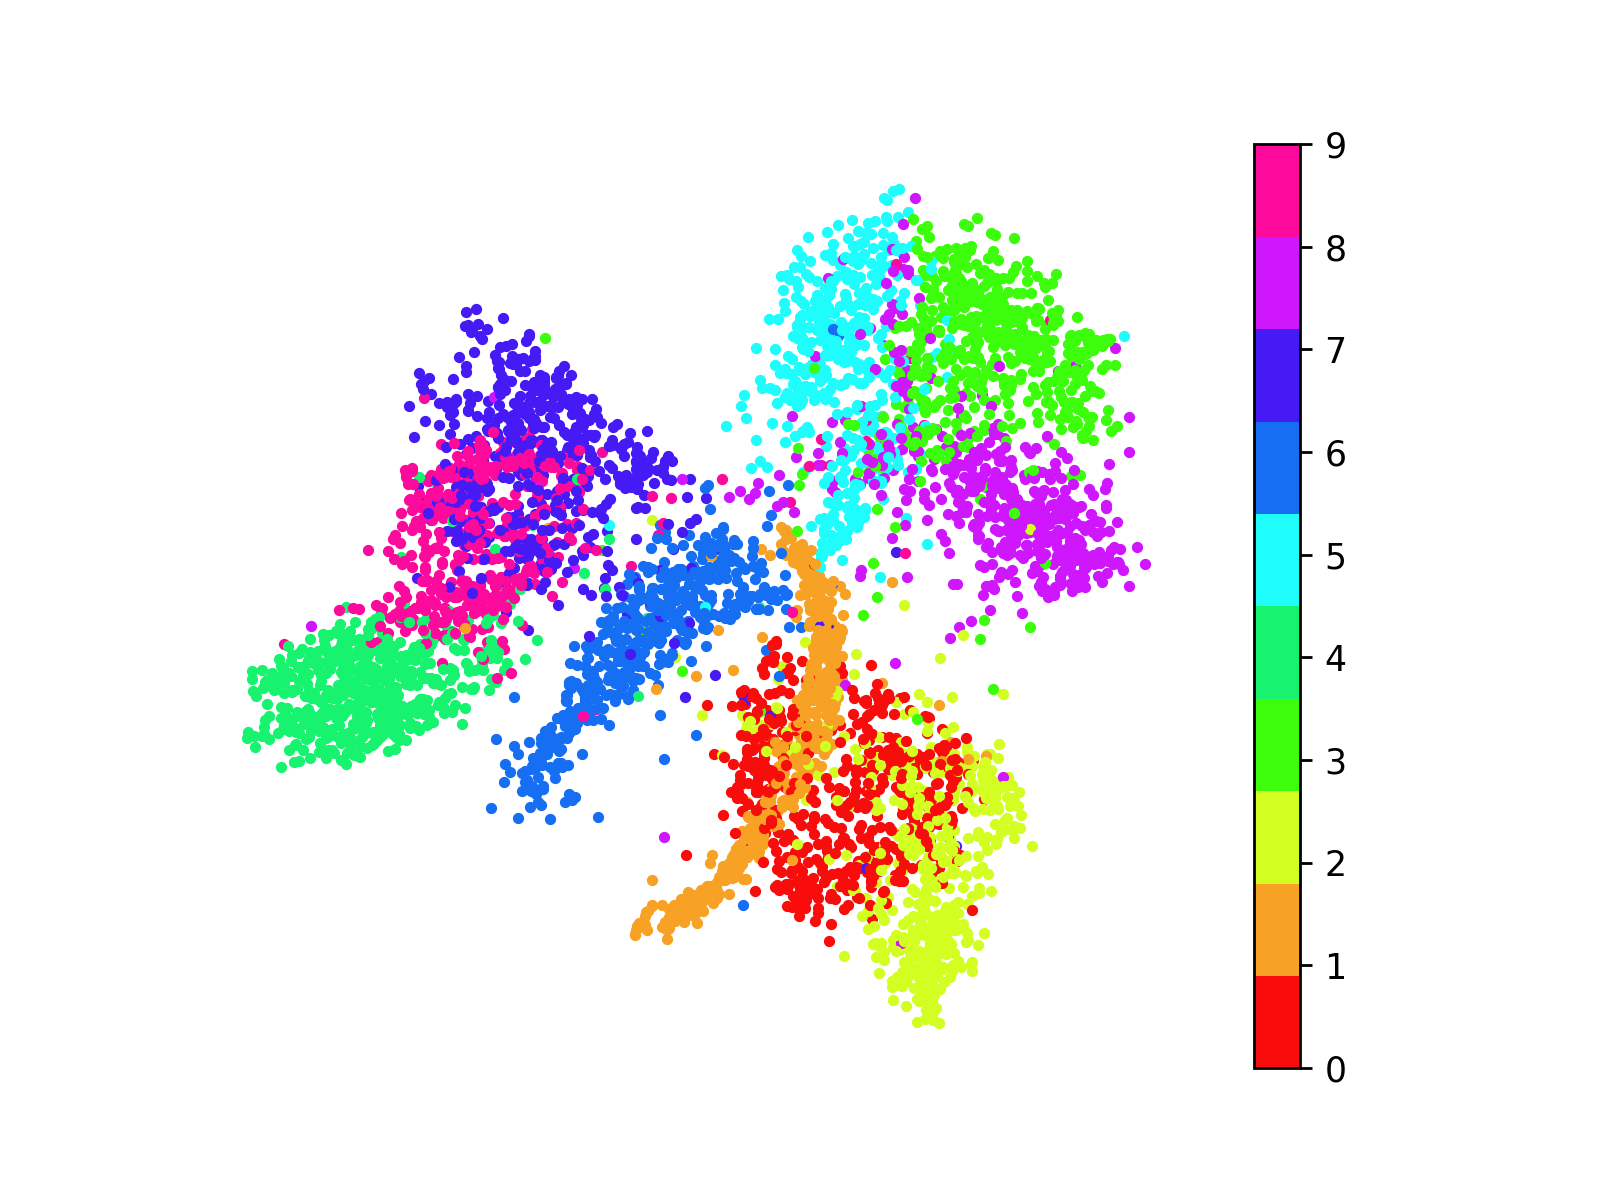

Finished networkx visualization in  271.65726375579834  secs


In [148]:
springyknn.viz_spring_graph(G, dim=2, iterations=150, scale=1.0)

In [200]:
x_train, y_train, x_cv, y_cv, x_test, y_test = partition_data(MX, My, training=0.1, cross_validation=0.9, test=0.0)

In [201]:
knn_classifier = KNNClassifier(x_train, y_train)

In [202]:
print(knn_classifier.accuracy(x_cv[:1000], y_cv[:1000], k=5))

0.943
